# Vehicle Loan Prediction Machine Learning Model

# 6. Random Forest

### Import Libraries and Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score

In [2]:
# Suppress warniing to avoid clutter in the output
warnings.filterwarnings("ignore")

In [3]:
# Load data
loan_df = pd.read_csv('../data/vehicle_loans_feat.csv', index_col='UNIQUEID')

Just like we did for Logistic Regression let's convert our categorical variables to the 'category' data type

In [4]:
# Convert categorical variables to 'category' data type for better performance
category_cols = ['MANUFACTURER_ID', 'STATE_ID', 'DISBURSAL_MONTH', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE_DESCRIPTION', 'EMPLOYMENT_TYPE']
loan_df[category_cols] = loan_df[category_cols].astype('category')

Now we can bring the plot_roc_curve and eval_model functions we defined

In [5]:
# Define function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [6]:
# Define function to evaluate the model
def eval_model(model, x_test, y_test):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    conf_mat = confusion_matrix(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    conf_mat_df = pd.DataFrame(conf_mat, 
                              index=['True Negatives', 'True Positives'],
                              columns=['False Negatives', 'False Positives'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat_df, annot=True, fmt='d', 
                linewidths=.5, square=True, cbar=False, 
                annot_kws={"size": 16})
    plt.title('Confusion Matrix')
    plt.show()

    #print(conf_mat)
    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    #Show ROC Curve 
    fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)

    plot_roc_curve(fpr, tpr, roc_auc)

    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs[:, 1]

    #plot the distribution of probabilities for the estimated classes 
    sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label="No Default", hist=False)
    sns.distplot(results_df[results_df['true_class'] == 1]['default_prob'], label="Default", hist=False)
    plt.title('Distribution of Probabilities for Estimated Classes')
    plt.legend(loc='best')
    plt.show()
    
    #see the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))


## Building The Forest

We will use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from sklearn to build a Random Forest model for our data


In [7]:
# Function to encode categorical variables and split data into training and test sets
def encode_and_split(loan_df):
    loan_data_dumm = pd.get_dummies(loan_df, prefix_sep='_', drop_first=True)

    x = loan_data_dumm.drop(['LOAN_DEFAULT'], axis=1)
    y = loan_data_dumm['LOAN_DEFAULT']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test

Now let's test our new function and create a training and test set for RandomForest, this time using the full set of features 

In [8]:
# Generate training and tests sets
x_train, x_test, y_train, y_test = encode_and_split(loan_df)

In [9]:
# Display shapes and class distribution of training and tests sets

print("Training Features Shape", x_train.shape)
print("Training Label Rows", y_train.count())

Training Features Shape (186523, 92)
Training Label Rows 186523


In [10]:
print("Testing Features Shape", x_test.shape)
print("Testing Label Rows", y_test.count())

Testing Features Shape (46631, 92)
Testing Label Rows 46631


In [11]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

LOAN_DEFAULT
0    0.783099
1    0.216901
Name: proportion, dtype: float64
LOAN_DEFAULT
0    0.782248
1    0.217752
Name: proportion, dtype: float64


Looks like we have a train and test set with the class distribution we want

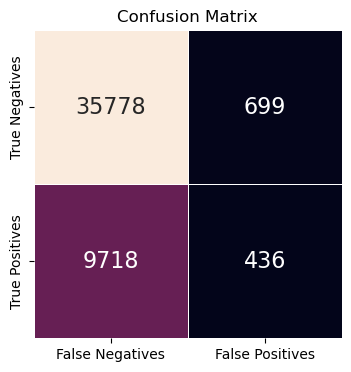



Accuracy:  0.7766078359889343
Precision:  0.3841409691629956
Recall:  0.04293874335237345
F1:  0.07724333421915139
AUC:  0.6224777756918541


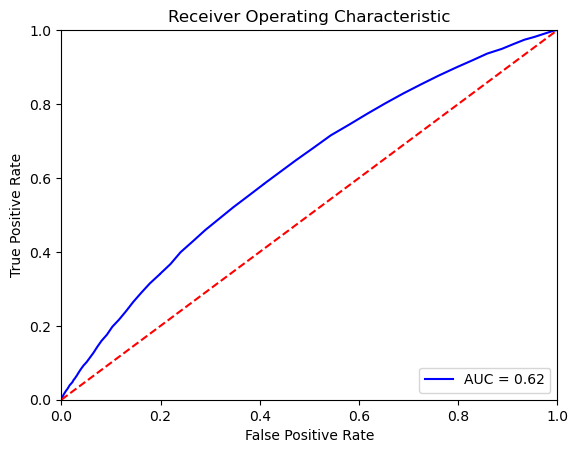

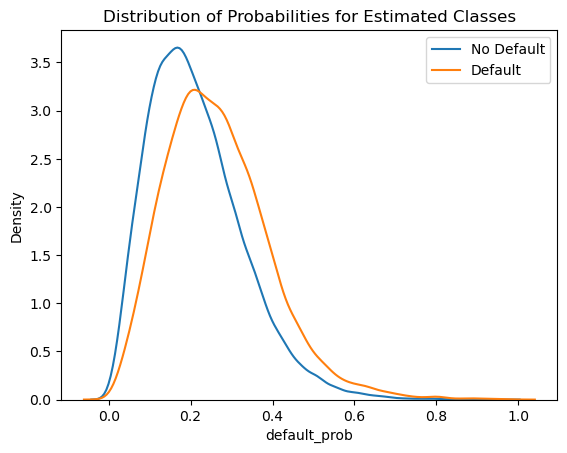

true_class  predicted_class
0           0                  0.980837
            1                  0.019163
1           0                  0.957061
            1                  0.042939
Name: proportion, dtype: float64


In [12]:
# Initialise and train Random Forest Classifier 
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

Let's take a minute to interpret these results 

### Accuracy 

- ~78% similar to the simple logistic regression model we built already

### Precision 

- 39% better than simple logistic Regression which had ~33% 
- More of the instances we classified as defaults actually were defaults 
- However, most of the instances we classify as defaults are actually not defaults

### Recall 

- Recall has increased dramatically, from 0.03% to 4.5%!
- Random Forest picked up a lot more of the actual positive cases
- It still missed most of them

### F1

- The F1 score has also increased dramatically from 0.0006 to ~0.08! 
- There is a better balance between Precision and Recall for Random Forest
- Although this is still generally poor

### AUC 

- The area under the roc curve has increased very slightly

### Probability Distributions 

- Plot shows bad class separation 
- Majority of cases unlikely to be classified as defaults 

Generally the random forest is better than Logistic Regression but it is still not doing a good job

## Overfitting

A model is said to be overfitted if it performs very well on training data but does not generalize well to unseen test data

We can look at evaluate our model's performance on the training data to investigate overfitting

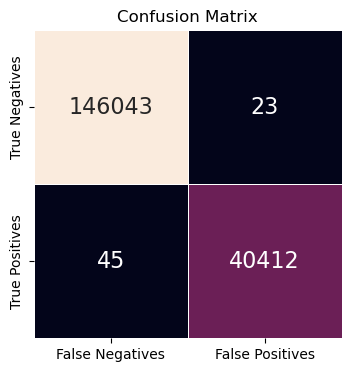



Accuracy:  0.9996354336998654
Precision:  0.9994311858538395
Recall:  0.9988877079368218
F1:  0.9991593729911487
AUC:  0.9999967315589371


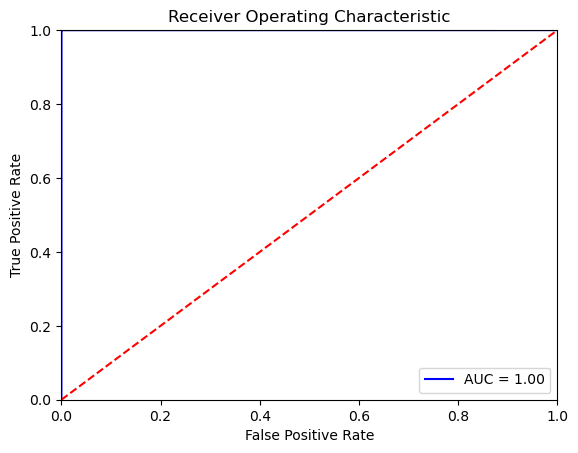

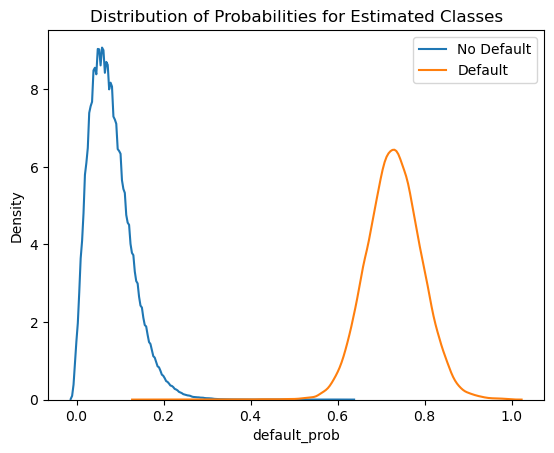

true_class  predicted_class
0           0                  0.999843
            1                  0.000157
1           1                  0.998888
            0                  0.001112
Name: proportion, dtype: float64


In [13]:
# Evaluate model's performance on training data to investigate overfitting
eval_model(rfc_model, x_train, y_train)

Pretty clear evidence that our random forest is overfitting, it has nearly perfect results on the training data and poor results on the test data

## Hyperparameters 

Classification performance of random forest can be heavily influenced by its hyperparameters

### Number of Trees 

Let's do some manual exploration of the forest size parameter, remember the default value is 100 

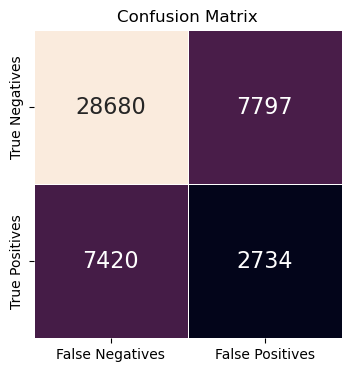



Accuracy:  0.6736720207587228
Precision:  0.2596144715601557
Recall:  0.2692534961591491
F1:  0.26434614454919025
AUC:  0.5279476512403938


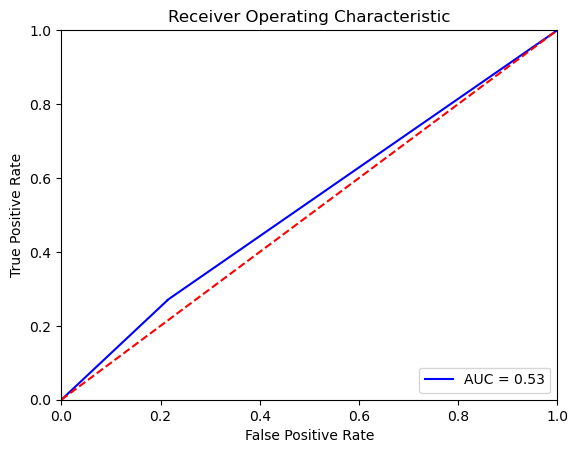

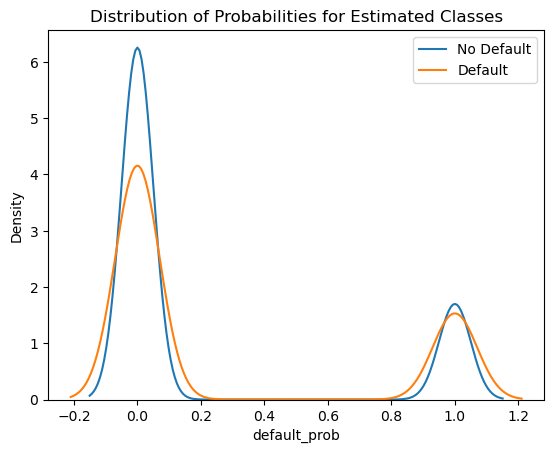

true_class  predicted_class
0           0                  0.786249
            1                  0.213751
1           0                  0.730747
            1                  0.269253
Name: proportion, dtype: float64


In [14]:
# Single tree model
rfc_model = RandomForestClassifier(n_estimators=1)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

- With a forest size of 1, the random forest behaves as a standalone decision tree and is unable to distinguish between the two classes
- With AUC of 0.52 it is only marginally better than a random classifier

Let's see what happens if we increase the number of trees to 10

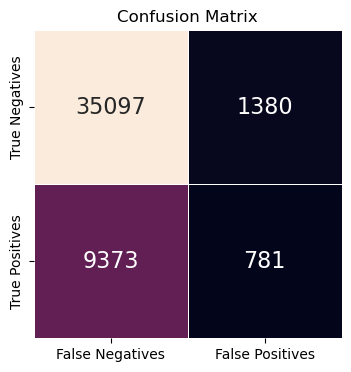



Accuracy:  0.7694023289228196
Precision:  0.36140675613142065
Recall:  0.07691550128028363
F1:  0.1268371904181892
AUC:  0.5831295399856655


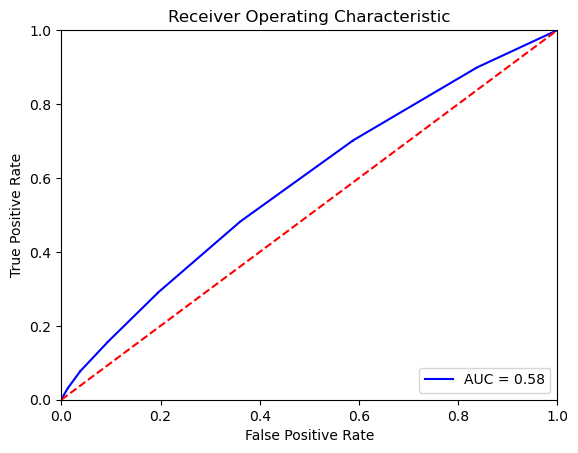

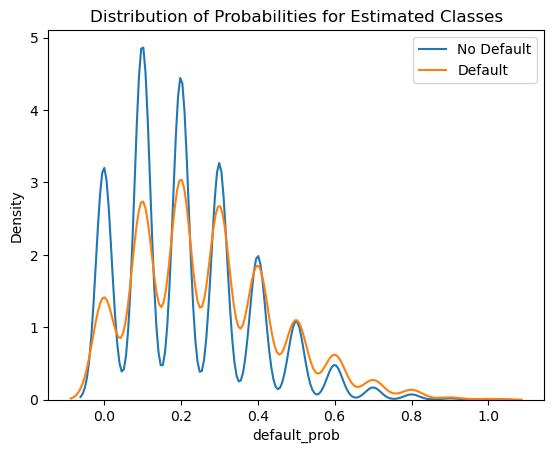

true_class  predicted_class
0           0                  0.962168
            1                  0.037832
1           0                  0.923084
            1                  0.076916
Name: proportion, dtype: float64


In [15]:
# Model with 10 trees
rfc_model = RandomForestClassifier(n_estimators=10)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

- We see here that with a forest size of 10 the separation ability of the model increases with an AUC of 0.58
- Multiple peaks on the distribution chart suggest that this is not a very stable model

How about with the default value of 100 trees?

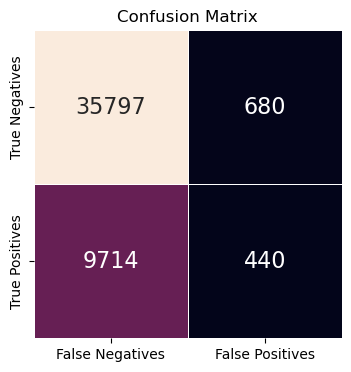



Accuracy:  0.7771010701035792
Precision:  0.39285714285714285
Recall:  0.04333267677762458
F1:  0.07805570338832712
AUC:  0.624478287545039


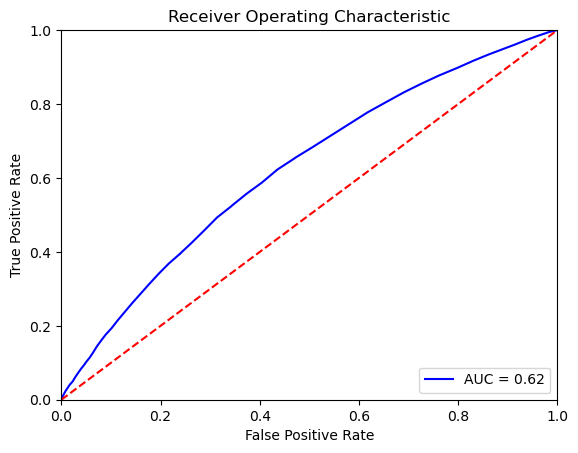

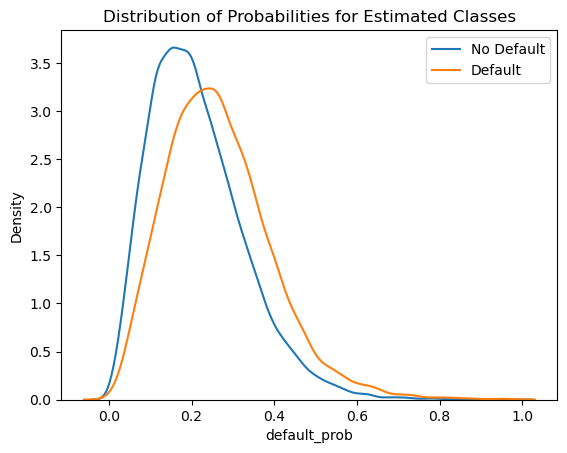

true_class  predicted_class
0           0                  0.981358
            1                  0.018642
1           0                  0.956667
            1                  0.043333
Name: proportion, dtype: float64


In [16]:
# Model with default 100 trees
rfc_model = RandomForestClassifier(n_estimators=100)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

- With 100 estimators the AUC improved from 0.58 to 0.62
- Class distributions appeared more defined and settled

What about if we increase to 300?

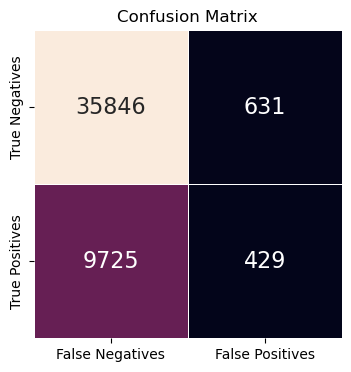



Accuracy:  0.7779159786408183
Precision:  0.4047169811320755
Recall:  0.04224935985818397
F1:  0.07651150347779562
AUC:  0.6270048620274826


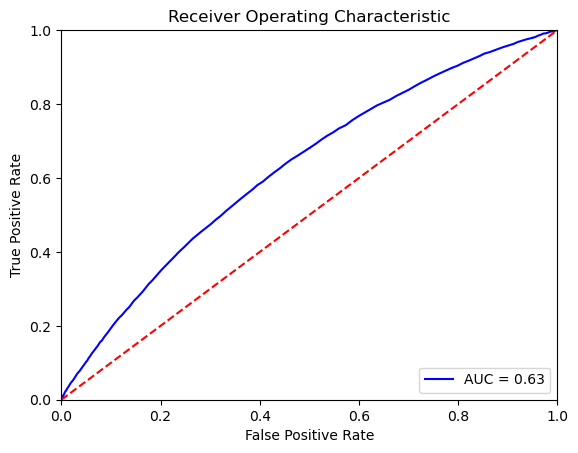

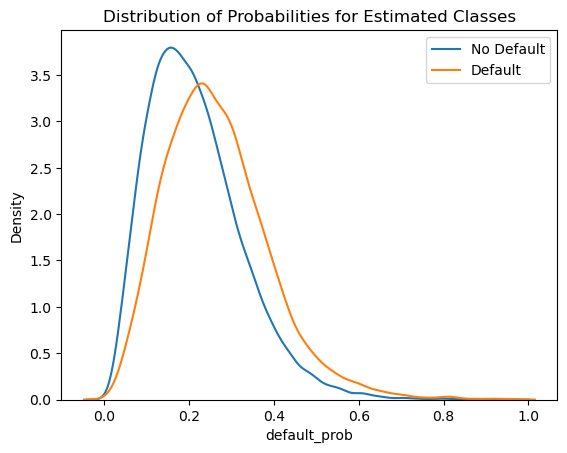

true_class  predicted_class
0           0                  0.982701
            1                  0.017299
1           0                  0.957751
            1                  0.042249
Name: proportion, dtype: float64


In [17]:
# Model with 300 trees 
rfc_model = RandomForestClassifier(n_estimators=300)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

Very similar performance to the default value of 100! 

Increasing the size of the forest helps classification performance up to a point

However, it also increases the computational cost of training the model

### Maximum Depth

We observed earlier that our random forest model is overfitting

One way of tackling overfitting in random forest is by limiting the Maximum Depth of the trees. This prevents the classifiers from growing to large picking up noise in the training data

The default value of max_depth is None (it is not limited!)

Let's do some experiments

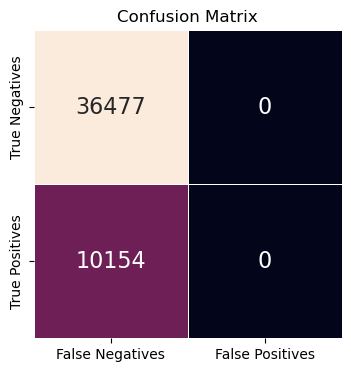



Accuracy:  0.7822478608650898
Precision:  0.0
Recall:  0.0
F1:  0.0
AUC:  0.6310760365973299


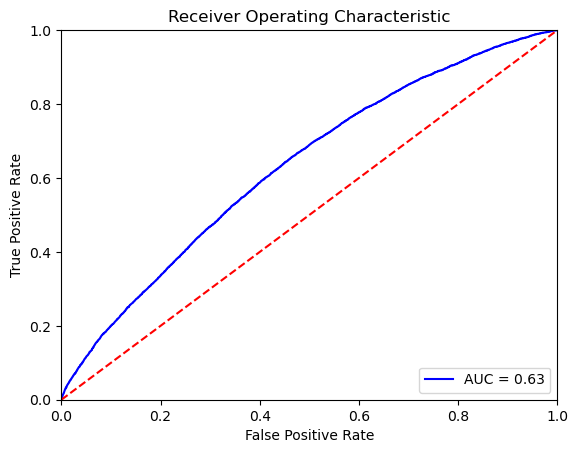

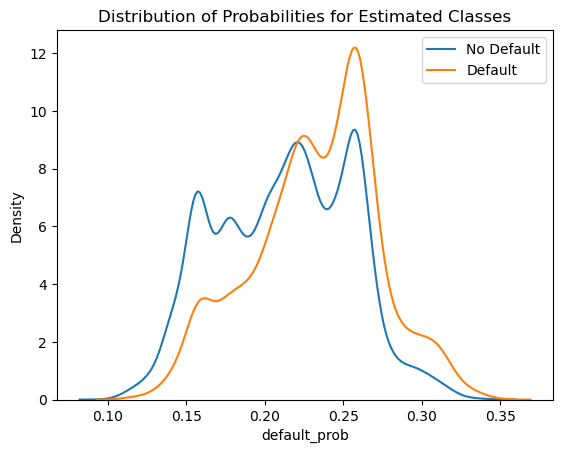

true_class  predicted_class
0           0                  1.0
1           0                  1.0
Name: proportion, dtype: float64


In [18]:
# Model with max_depth=5
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

We have increased the AUC but the model is failing to identify any loan defaults

Let's take a look at how it performs on the training data

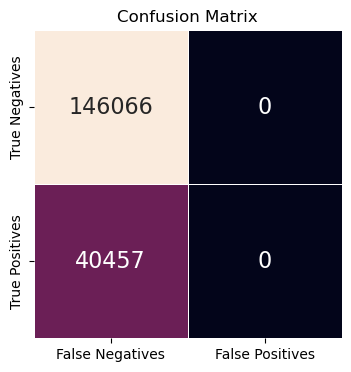



Accuracy:  0.783099135227291
Precision:  0.0
Recall:  0.0
F1:  0.0
AUC:  0.6399982420053172


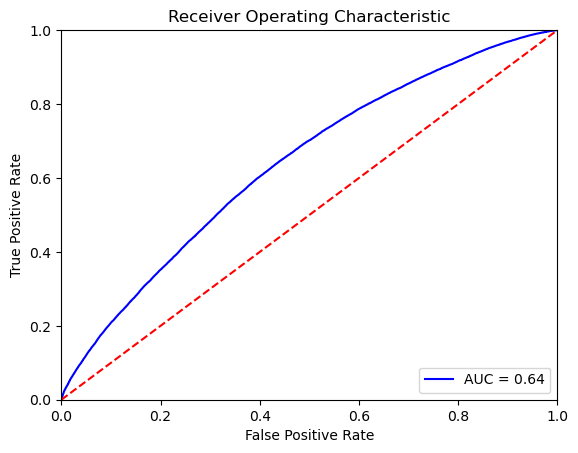

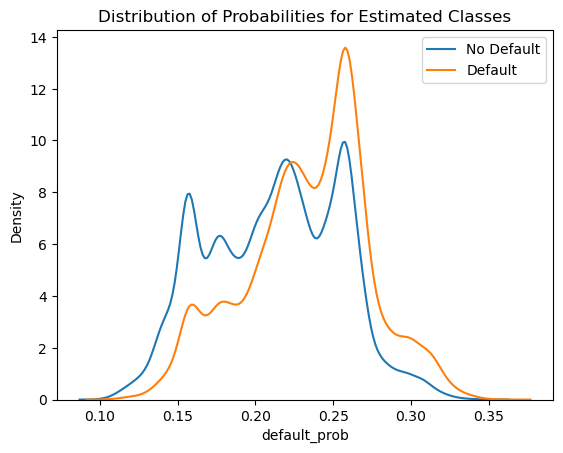

true_class  predicted_class
0           0                  1.0
1           0                  1.0
Name: proportion, dtype: float64


In [19]:
# Evaluate on training data to check for overfitting
eval_model(rfc_model, x_train, y_train)

As with the test data, the model is not identifying any defaults.

Very similar performance between training and test data tells us we are not overfitting anymore, but the model has very little predictive power

Limiting the tree size to 5 has probably oversimplified the model and actually given us an underfit model!

Let's try again with a larger max_depth

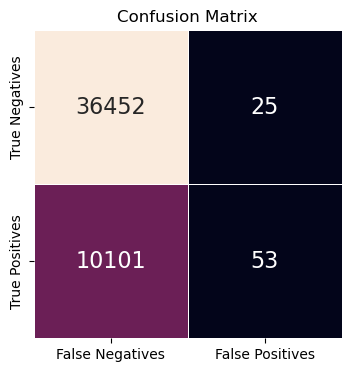



Accuracy:  0.782848319787266
Precision:  0.6794871794871795
Recall:  0.005219617884577506
F1:  0.01035965598123534
AUC:  0.646617820952242


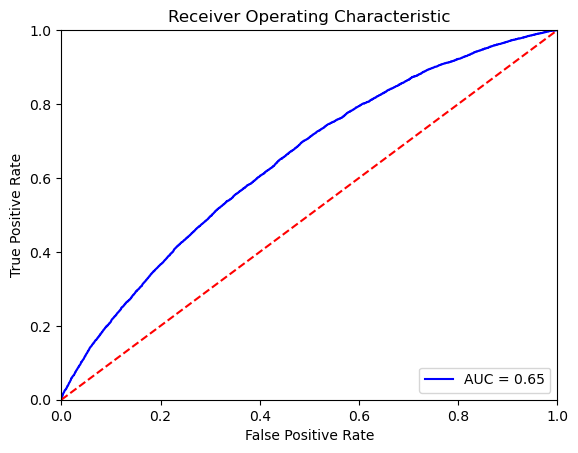

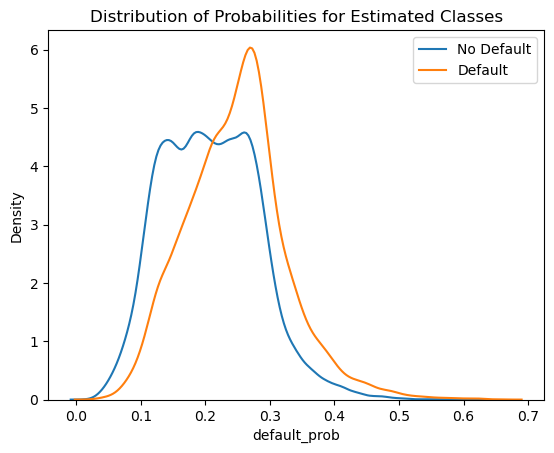

true_class  predicted_class
0           0                  0.999315
            1                  0.000685
1           0                  0.994780
            1                  0.005220
Name: proportion, dtype: float64


In [20]:
# Model with max_depth=15
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

A few things to note here! 

We have increased the AUC to ~0.65, this model has the best ability to separate classes that we have seen so far! 

It is also has a very good precision score of 67%, but we are still identifying very few loan defaults hence the poor recall

Let's have a look at the training set performance!

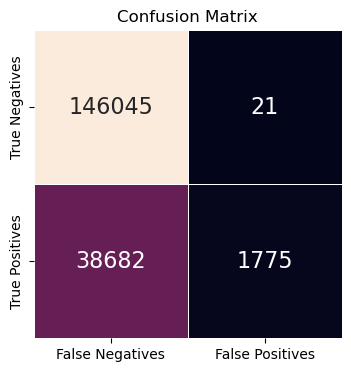



Accuracy:  0.792502801263115
Precision:  0.9883073496659243
Recall:  0.04387374249202857
F1:  0.08401770288500225
AUC:  0.8273994516629273


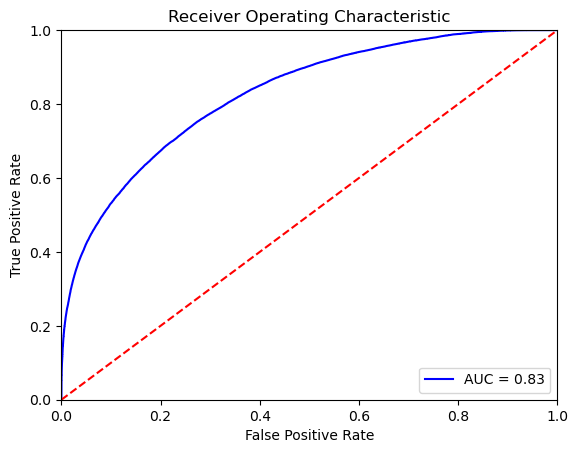

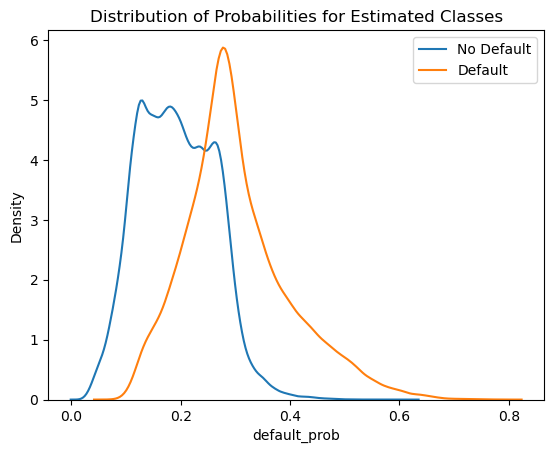

true_class  predicted_class
0           0                  0.999856
            1                  0.000144
1           0                  0.956126
            1                  0.043874
Name: proportion, dtype: float64


In [21]:
# Evaluate on training data to check for overfitting
eval_model(rfc_model, x_train, y_train)

Our model does perform better on the training data so it could be a little overfitted. However, it certainly is much less dramatic than before! 

We have now limited the complexity of the trees in our forest which has reduced overfitting. 